<a href="https://colab.research.google.com/github/twishi03/liver/blob/master/WSI_HE_SegNuclei_Tiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load WSI svs and cropping tiles
!apt update && apt install -y openslide-tools
!pip install openslide-python
!pip install opencv-python

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,230 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,087 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-backport

In [2]:
from openslide import open_slide
import openslide
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import tifffile as tiff
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [3]:
 #Load the slide file (svs) into an object.
slide = open_slide("/content/GTEX-1LSNM-0526.svs")

In [4]:
slide_props = slide.properties
print(slide_props)

print("Vendor is:", slide_props['openslide.vendor'])
print("Pixel size of X in um is:", slide_props['openslide.mpp-x'])
print("Pixel size of Y in um is:", slide_props['openslide.mpp-y'])

<_PropertyMap {'aperio.AppMag': '20', 'aperio.DSR ID': 'vaiaperio03', 'aperio.Date': '05/01/15', 'aperio.DisplayColor': '0', 'aperio.Exposure Scale': '0.000001', 'aperio.Exposure Time': '109', 'aperio.Filename': '83831', 'aperio.Focus Offset': '-0.000500', 'aperio.ICC Profile': 'ScanScope v1', 'aperio.ImageID': '83831', 'aperio.Left': '14.624326', 'aperio.LineAreaXOffset': '0.023001', 'aperio.LineAreaYOffset': '-0.006920', 'aperio.LineCameraSkew': '0.001659', 'aperio.MPP': '0.4942', 'aperio.OriginalHeight': '22667', 'aperio.OriginalWidth': '40640', 'aperio.ScanScope ID': 'SS1553', 'aperio.StripeWidth': '2032', 'aperio.Time': '14:40:16', 'aperio.Time Zone': 'GMT-04:00', 'aperio.Top': '17.473372', 'aperio.User': '72d07734-9fbe-4dbf-a3a2-e6427426477f', 'openslide.comment': 'Aperio Image Library v12.0.11 \r\n40640x22667 [0,100 39839x22567] (240x240) JPEG/RGB Q=70|AppMag = 20|StripeWidth = 2032|ScanScope ID = SS1553|Filename = 83831|Date = 05/01/15|Time = 14:40:16|Time Zone = GMT-04:00|User

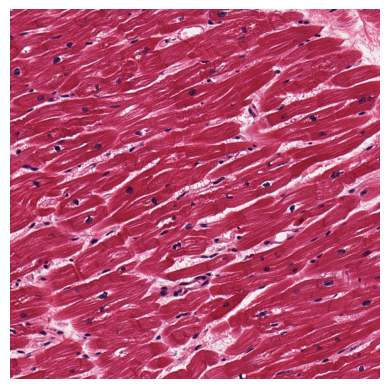

In [9]:
#Extracting a small region and processing it

#Load a level image, normalize the image and digitally extract H and E images
#As described in video 122: https://www.youtube.com/watch?v=yUrwEYgZUsA
#Extract 1024,1024 region
smaller_region = slide.read_region((8000,8000), 0, (1024,1024))
smaller_region_RGB = smaller_region.convert('RGB')
smaller_region_np = np.array(smaller_region_RGB)

plt.axis('off')
plt.imshow(smaller_region_np)



In [10]:
# Stain Normalization Step
def norm_HnE(img, Io=240, alpha=1, beta=0.15):


    ######## Step 1: Convert RGB to OD ###################
    ## reference H&E OD matrix.
    #Can be updated if you know the best values for your image.
    #Otherwise use the following default values.
    #Read the above referenced papers on this topic.
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
    ### reference maximum stain concentrations for H&E
    maxCRef = np.array([1.9705, 1.0308])


    # extract the height, width and num of channels of image
    h, w, c = img.shape

    # reshape image to multiple rows and 3 columns.
    #Num of rows depends on the image size (wxh)
    img = img.reshape((-1,3))

    # calculate optical density
    # OD = −log10(I)
    #OD = -np.log10(img+0.004)  #Use this when reading images with skimage
    #Adding 0.004 just to avoid log of zero.

    OD = -np.log10((img.astype(np.float)+1)/Io) #Use this for opencv imread
    #Add 1 in case any pixels in the image have a value of 0 (log 0 is indeterminate)


    ############ Step 2: Remove data with OD intensity less than β ############
    # remove transparent pixels (clear region with no tissue)
    ODhat = OD[~np.any(OD < beta, axis=1)] #Returns an array where OD values are above beta
    #Check by printing ODhat.min()

    ############# Step 3: Calculate SVD on the OD tuples ######################
    #Estimate covariance matrix of ODhat (transposed)
    # and then compute eigen values & eigenvectors.
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))


    ######## Step 4: Create plane from the SVD directions with two largest values ######
    #project on the plane spanned by the eigenvectors corresponding to the two
    # largest eigenvalues
    That = ODhat.dot(eigvecs[:,1:3]) #Dot product

    ############### Step 5: Project data onto the plane, and normalize to unit length ###########
    ############## Step 6: Calculate angle of each point wrt the first SVD direction ########
    #find the min and max vectors and project back to OD space
    phi = np.arctan2(That[:,1],That[:,0])

    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)

    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)


    # a heuristic to make the vector corresponding to hematoxylin first and the
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:
        HE = np.array((vMin[:,0], vMax[:,0])).T

    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T


    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T

    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]

    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])

    ###### Step 8: Convert extreme values back to OD space
    # recreate the normalized image using reference mixing matrix

    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)

    # Separating H and E components

    H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
    H[H>255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)

    E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
    E[E>255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)

    return (Inorm, H, E)

<ipython-input-10-fa33fef09b6f>:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  OD = -np.log10((img.astype(np.float)+1)/Io) #Use this for opencv imread


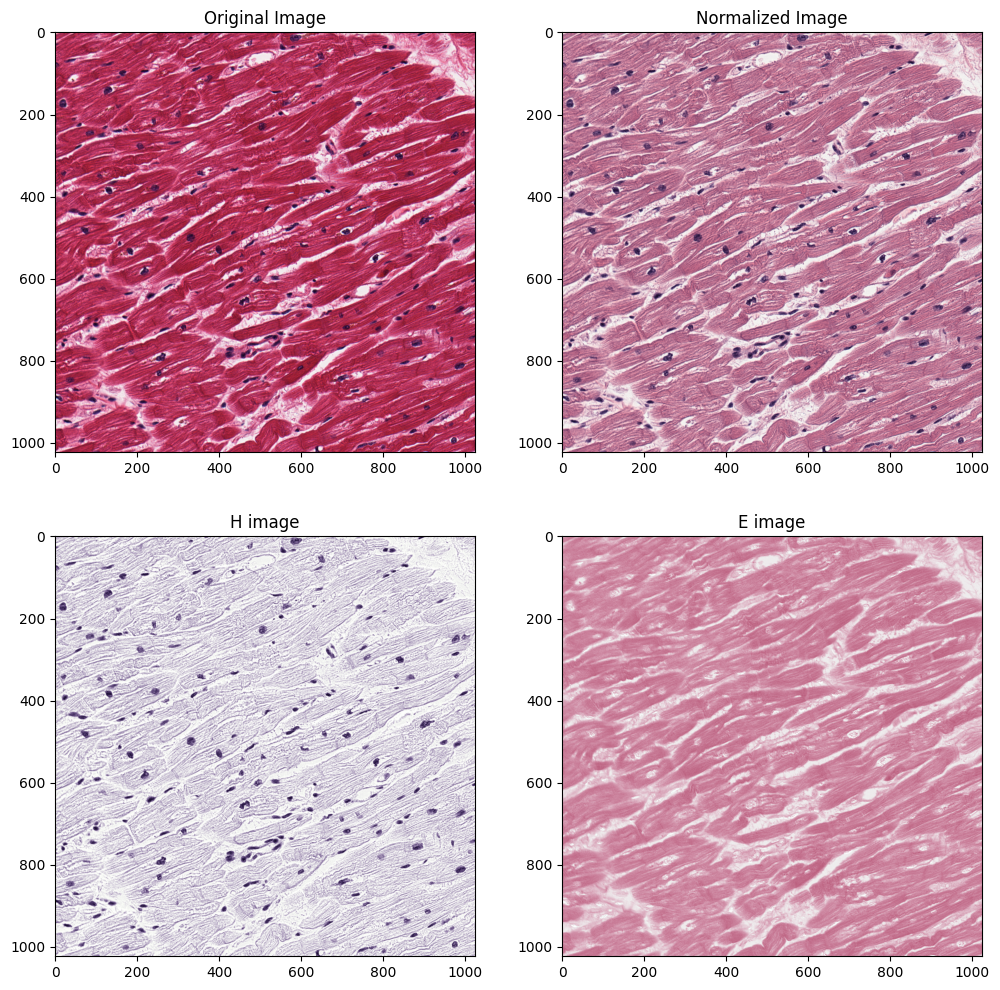

In [11]:
norm_img, H_img, E_img = norm_HnE(smaller_region_np, Io=240, alpha=1, beta=0.15)



plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Original Image')
plt.imshow(smaller_region_np)
plt.subplot(222)
plt.title('Normalized Image')
plt.imshow(norm_img)
plt.subplot(223)
plt.title('H image')
plt.imshow(H_img)
plt.subplot(224)
plt.title('E image')
plt.imshow(E_img)
plt.show()

In [12]:
def find_mean_std_pixel_value(img_list):

    avg_pixel_value = []
    stddev_pixel_value= []
    for file in img_list:
        image = tiff.imread(file)
        avg = image.mean()
        std = image.std()
        avg_pixel_value.append(avg)
        stddev_pixel_value.append(std)

    avg_pixel_value = np.array(avg_pixel_value)
    stddev_pixel_value=np.array(stddev_pixel_value)

    print("Average pixel value for all images is:", avg_pixel_value.mean())
    print("Average std dev of pixel value for all images is:", stddev_pixel_value.mean())

    return(avg_pixel_value, stddev_pixel_value)

In [ ]:
#Objective used to capture the image
objective = float(slide.properties[openslide.PROPERTY_NAME_OBJECTIVE_POWER])
print("The objective power is: ", objective)

The objective power is:  20.0


In [ ]:
# get slide dimensions for the level 0 - max resolution level
slide_dims = slide.dimensions
print(slide_dims)

(39839, 22567)


In [ ]:
#Get a thumbnail of the image and visualize
slide_thumb_600 = slide.get_thumbnail(size=(600, 600))
slide_thumb_600.show()

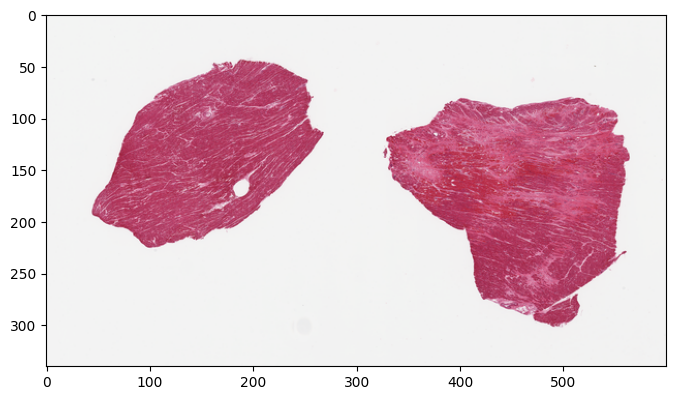

In [ ]:
#Convert thumbnail to numpy array
slide_thumb_600_np = np.array(slide_thumb_600)
plt.figure(figsize=(8,8))
plt.imshow(slide_thumb_600_np)

In [ ]:
#Get slide dims at each level. Remember that whole slide images store information
#as pyramid at various levels
dims = slide.level_dimensions

In [ ]:
num_levels = len(dims)
print("Number of levels in this image are:", num_levels)

print("Dimensions of various levels in this image are:", dims)

Number of levels in this image are: 3
Dimensions of various levels in this image are: ((39839, 22567), (9959, 5641), (2489, 1410))


In [ ]:
#By how much are levels downsampled from the original image?
factors = slide.level_downsamples
print("Each level is downsampled by an amount of: ", factors)

Each level is downsampled by an amount of:  (1.0, 4.000416527831473, 16.005495527840225)


In [ ]:
#Copy an image from a level
level3_dim = dims[2]
#Give pixel coordinates (top left pixel in the original large image)
#Also give the level number (for level 3 we are providing a valueof 2)
#Size of your output image
#Remember that the output would be a RGBA image (Not, RGB)
level3_img = slide.read_region((0,0), 2, level3_dim) #Pillow object, mode=RGBA

In [ ]:
#Convert the image to RGB
level3_img_RGB = level3_img.convert('RGB')
level3_img_RGB.show()

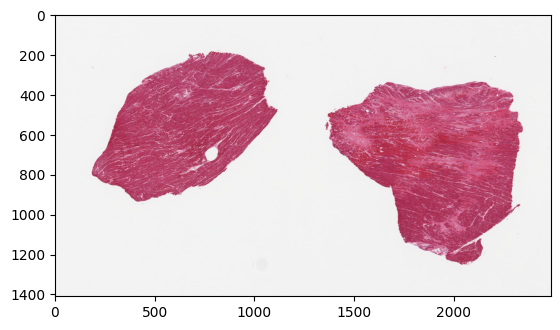

In [ ]:
#Convert the image into numpy array for processing
level3_img_np = np.array(level3_img_RGB)
plt.imshow(level3_img_np)

In [13]:
#Generating tiles for deep learning training or other processing purposes
#We can use read_region function and slide over the large image to extract tiles
#but an easier approach would be to use DeepZoom based generator.
# https://openslide.org/api/python/

from openslide.deepzoom import DeepZoomGenerator

In [14]:
#Generate object for tiles using the DeepZoomGenerator
tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)

In [15]:
#Here, we have divided our svs into tiles of size 256 with no overlap.

#The tiles object also contains data at many levels.
#To check the number of levels
print("The number of levels in the tiles object are: ", tiles.level_count)

print("The dimensions of data in each level are: ", tiles.level_dimensions)

The number of levels in the tiles object are:  17
The dimensions of data in each level are:  ((1, 1), (2, 1), (3, 2), (5, 3), (10, 6), (20, 12), (39, 23), (78, 45), (156, 89), (312, 177), (623, 353), (1245, 706), (2490, 1411), (4980, 2821), (9960, 5642), (19920, 11284), (39839, 22567))


In [16]:
#Total number of tiles in the tiles object
print("Total number of tiles = : ", tiles.tile_count)

Total number of tiles = :  18623


In [17]:
#How many tiles at a specific level?
level_num = 11
print("Tiles shape at level ", level_num, " is: ", tiles.level_tiles[level_num])
print("This means there are ", tiles.level_tiles[level_num][0]*tiles.level_tiles[level_num][1], " total tiles in this level")


Tiles shape at level  11  is:  (5, 3)
This means there are  15  total tiles in this level


In [18]:
###### Saving each tile to local directory
cols, rows = tiles.level_tiles[16]

In [19]:
# Folder for saving original cropped tiles
import os
tile_dir = "/content/tiles"
for row in range(rows):
    for col in range(cols):
        tile_name = os.path.join(tile_dir, '%d_%d' % (col, row))
        print("Now saving tile with title: ", tile_name)
        temp_tile = tiles.get_tile(16, (col, row))
        temp_tile_RGB = temp_tile.convert('RGB')
        temp_tile_np = np.array(temp_tile_RGB)
        plt.imsave(tile_name + ".png", temp_tile_np)

Streaming output truncated to the last 5000 lines.
Now saving tile with title:  /content/tiles/148_56
Now saving tile with title:  /content/tiles/149_56
Now saving tile with title:  /content/tiles/150_56
Now saving tile with title:  /content/tiles/151_56
Now saving tile with title:  /content/tiles/152_56
Now saving tile with title:  /content/tiles/153_56
Now saving tile with title:  /content/tiles/154_56
Now saving tile with title:  /content/tiles/155_56
Now saving tile with title:  /content/tiles/0_57
Now saving tile with title:  /content/tiles/1_57
Now saving tile with title:  /content/tiles/2_57
Now saving tile with title:  /content/tiles/3_57
Now saving tile with title:  /content/tiles/4_57
Now saving tile with title:  /content/tiles/5_57
Now saving tile with title:  /content/tiles/6_57
Now saving tile with title:  /content/tiles/7_57
Now saving tile with title:  /content/tiles/8_57
Now saving tile with title:  /content/tiles/9_57
Now saving tile with title:  /content/tiles/10_57
N

In [20]:
###### processing and saving each tile to local directory
cols, rows = tiles.level_tiles[16]

#Location of orginal tiles folder
orig_tile_dir_name = "/content/tiles"
#Location of tiles to be stored after processing
norm_tile_dir_name = "/content/normalized_tiles"
H_tile_dir_name = "/content/H_tiles"
E_tile_dir_name = "/content/E_tiles"

for row in range(rows):
    for col in range(cols):
        tile_name = str(col) + "_" + str(row)
        #tile_name = os.path.join(tile_dir, '%d_%d' % (col, row))
        #print("Now processing tile with title: ", tile_name)
        temp_tile = tiles.get_tile(16, (col, row))
        temp_tile_RGB = temp_tile.convert('RGB')
        temp_tile_np = np.array(temp_tile_RGB)
        #Save original tile
        plt.imsave(orig_tile_dir_name+tile_name + "_original.png", temp_tile_np)

        if temp_tile_np.mean() < 230 and temp_tile_np.std() > 15:
            print("Processing tile number:", tile_name)
            norm_img, H_img, E_img = norm_HnE(temp_tile_np, Io=240, alpha=1, beta=0.15)
        #Save the norm tile, H and E tiles

            plt.imsave(norm_tile_dir_name+tile_name + "_norm.png", norm_img)
            plt.imsave(H_tile_dir_name+tile_name + "_H.png", H_img)
            plt.imsave(E_tile_dir_name+tile_name + "_E.png", E_img)

        else:
            print("NOT PROCESSING TILE:", tile_name)


NOT PROCESSING TILE: 0_0
NOT PROCESSING TILE: 1_0
NOT PROCESSING TILE: 2_0
NOT PROCESSING TILE: 3_0
NOT PROCESSING TILE: 4_0
NOT PROCESSING TILE: 5_0
NOT PROCESSING TILE: 6_0
NOT PROCESSING TILE: 7_0
NOT PROCESSING TILE: 8_0
NOT PROCESSING TILE: 9_0
NOT PROCESSING TILE: 10_0
NOT PROCESSING TILE: 11_0
NOT PROCESSING TILE: 12_0
NOT PROCESSING TILE: 13_0
NOT PROCESSING TILE: 14_0
NOT PROCESSING TILE: 15_0
NOT PROCESSING TILE: 16_0
NOT PROCESSING TILE: 17_0
NOT PROCESSING TILE: 18_0
NOT PROCESSING TILE: 19_0
NOT PROCESSING TILE: 20_0
NOT PROCESSING TILE: 21_0
NOT PROCESSING TILE: 22_0
NOT PROCESSING TILE: 23_0
NOT PROCESSING TILE: 24_0
NOT PROCESSING TILE: 25_0
NOT PROCESSING TILE: 26_0
NOT PROCESSING TILE: 27_0
NOT PROCESSING TILE: 28_0
NOT PROCESSING TILE: 29_0
NOT PROCESSING TILE: 30_0
NOT PROCESSING TILE: 31_0
NOT PROCESSING TILE: 32_0
NOT PROCESSING TILE: 33_0
NOT PROCESSING TILE: 34_0
NOT PROCESSING TILE: 35_0
NOT PROCESSING TILE: 36_0
NOT PROCESSING TILE: 37_0
NOT PROCESSING TILE: 3

<ipython-input-10-fa33fef09b6f>:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  OD = -np.log10((img.astype(np.float)+1)/Io) #Use this for opencv imread


Processing tile number: 49_11
Processing tile number: 50_11
Processing tile number: 51_11
Processing tile number: 52_11
Processing tile number: 53_11
NOT PROCESSING TILE: 54_11
NOT PROCESSING TILE: 55_11
NOT PROCESSING TILE: 56_11
NOT PROCESSING TILE: 57_11
NOT PROCESSING TILE: 58_11
NOT PROCESSING TILE: 59_11
NOT PROCESSING TILE: 60_11
NOT PROCESSING TILE: 61_11
NOT PROCESSING TILE: 62_11
NOT PROCESSING TILE: 63_11
NOT PROCESSING TILE: 64_11
NOT PROCESSING TILE: 65_11
NOT PROCESSING TILE: 66_11
NOT PROCESSING TILE: 67_11
NOT PROCESSING TILE: 68_11
NOT PROCESSING TILE: 69_11
NOT PROCESSING TILE: 70_11
NOT PROCESSING TILE: 71_11
NOT PROCESSING TILE: 72_11
NOT PROCESSING TILE: 73_11
NOT PROCESSING TILE: 74_11
NOT PROCESSING TILE: 75_11
NOT PROCESSING TILE: 76_11
NOT PROCESSING TILE: 77_11
NOT PROCESSING TILE: 78_11
NOT PROCESSING TILE: 79_11
NOT PROCESSING TILE: 80_11
NOT PROCESSING TILE: 81_11
NOT PROCESSING TILE: 82_11
NOT PROCESSING TILE: 83_11
NOT PROCESSING TILE: 84_11
NOT PROCESSIN

KeyboardInterrupt: ignored